# ML-model initialisation and execution

In [1]:
from conflict_model import utils, pipeline, evaluation, plots

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sbs
import os, sys
from sklearn import metrics
import warnings
warnings.simplefilter("ignore")

For better reproducibility, the version numbers of all key packages are provided.

In [2]:
utils.show_versions()

Python version: 3.7.7 (default, Apr 15 2020, 05:09:04) [MSC v.1916 64 bit (AMD64)]
conflict_model version: 0.0.5b
geopandas version: 0.8.0
xarray version: 0.15.1
rasterio version: 1.1.0
pandas version: 1.0.3
numpy version: 1.18.1
scikit-learn version: 0.22.1
matplotlib version: 3.2.1
seaborn version: 0.10.1
rasterstats version: 0.14.0


## Read pre-computed XY-data

In the cfg-file, all the settings for the analysis are defined. By 'parsing' (i.e. reading) it, all settings and file paths are known to the model. This is a simple way to make the code independent of the input data and settings.

In [3]:
settings_file = 'example_settings.cfg'

Based on this cfg-file, the set-up of the run can be initialized. One part of the cfg-file is the specification and creation of an output folder.

In [4]:
config, out_dir = utils.initiate_setup(settings_file)

saving output to folder C:\Users\hoch0001\Documents\_code\conflict_model\example\OUT

no conflict file was specified, hence downloading data from http://ucdp.uu.se/downloads/ged/ged201-csv.zip to C:\Users\hoch0001\Documents\_code\conflict_model\example\example_data\UCDP\ged201-csv.zip



Since no XY-data is specified in the config-file initially, we have to set this manually.

In [5]:
config.set('pre_calc', 'XY', str(os.path.join(os.path.abspath(config.get('general', 'input_dir')), 'XY.npy')))

See if the right path pops up:

In [6]:
config.get('pre_calc', 'XY')

'C:\\Users\\hoch0001\\Documents\\_code\\conflict_model\\example\\example_data\\XY.npy'

Now that this is taken care of, we also need to load in the data from the very first notebook.

In [7]:
conflict_gdf = gpd.read_file(os.path.join(out_dir, 'selected_conflicts.shp'))
selected_polygons_gdf = gpd.read_file(os.path.join(out_dir, 'selected_polygons.shp'))

Again, for the conversion from numpy array to dataframe this requires a few more steps.

In [8]:
global_arr = np.load(os.path.join(out_dir, 'global_df.npy'), allow_pickle=True)
global_df = pd.DataFrame(data=global_arr, columns=['geometry', 'ID'])
global_df.set_index(global_df.ID, inplace=True)
global_df.drop(['ID'] , axis=1, inplace=True)

The scence is set now and we can compute the X-array and Y-array in no time!

In [9]:
X, Y = pipeline.create_XY(config, conflict_gdf, selected_polygons_gdf)

loading XY data from file C:\Users\hoch0001\Documents\_code\conflict_model\example\example_data\XY.npy

number of data points including missing values: 4110
number of data points excluding missing values: 4005
from this, 619 points are equal to 1, i.e. represent conflict occurence. This is a fraction of 15.46 percent.


## Scaler and classifier

In [10]:
scaler, clf = pipeline.prepare_ML(config)

chosen scaling method is QuantileTransformer(copy=True, ignore_implicit_zeros=False, n_quantiles=1000,
                    output_distribution='uniform', random_state=None,
                    subsample=100000)
chosen ML model is RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={1: 100},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


## Output initialization

Since the model is run multiple times, we need to initialize some stuff first to append the output per run.

In [11]:
out_X_df = evaluation.init_out_df()
out_y_df = evaluation.init_out_df()

In [12]:
out_dict = evaluation.init_out_dict()

In [13]:
trps, aucs, mean_fpr = evaluation.init_out_ROC_curve()

## ML-model execution

The pudels kern! This is where the magic happens, and not only once. Due make sure that any conincidental results are ruled out, we run the model multiple times. Thereby, always different samples are used for training and prediction. By using a sufficient number of runs and averaging the overall results, we should be able to get a good picture of what the model is capable of.

The main evaluation metric is the mean ROC-score and [**ROC-curve**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_roc_curve.html), plotted at the end of all runs.

run 1 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.837
Precision: 0.468
Recall: 0.270
F1 score: 0.342
Brier loss score: 0.111
Cohen-Kappa score: 0.257
ROC AUC score 0.811

              precision    recall  f1-score   support

           0       0.87      0.94      0.91      1013
           1       0.47      0.27      0.34       189

    accuracy                           0.84      1202
   macro avg       0.67      0.61      0.62      1202
weighted avg       0.81      0.84      0.82      1202




No handles with labels found to put in legend.


run 2 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.861
Precision: 0.589
Recall: 0.290
F1 score: 0.388
Brier loss score: 0.099
Cohen-Kappa score: 0.320
ROC AUC score 0.844

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1019
           1       0.59      0.29      0.39       183

    accuracy                           0.86      1202
   macro avg       0.74      0.63      0.65      1202
weighted avg       0.84      0.86      0.84      1202




No handles with labels found to put in legend.


run 3 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.856
Precision: 0.535
Recall: 0.300
F1 score: 0.384
Brier loss score: 0.105
Cohen-Kappa score: 0.310
ROC AUC score 0.822

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1022
           1       0.53      0.30      0.38       180

    accuracy                           0.86      1202
   macro avg       0.71      0.63      0.65      1202
weighted avg       0.83      0.86      0.84      1202




No handles with labels found to put in legend.


run 4 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.854
Precision: 0.540
Recall: 0.257
F1 score: 0.348
Brier loss score: 0.106
Cohen-Kappa score: 0.277
ROC AUC score 0.818

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1019
           1       0.54      0.26      0.35       183

    accuracy                           0.85      1202
   macro avg       0.71      0.61      0.63      1202
weighted avg       0.83      0.85      0.83      1202




No handles with labels found to put in legend.


run 5 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.853
Precision: 0.566
Recall: 0.295
F1 score: 0.388
Brier loss score: 0.107
Cohen-Kappa score: 0.313
ROC AUC score 0.832

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1012
           1       0.57      0.29      0.39       190

    accuracy                           0.85      1202
   macro avg       0.72      0.63      0.65      1202
weighted avg       0.83      0.85      0.83      1202




No handles with labels found to put in legend.


run 6 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.855
Precision: 0.590
Recall: 0.259
F1 score: 0.360
Brier loss score: 0.105
Cohen-Kappa score: 0.292
ROC AUC score 0.833

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1013
           1       0.59      0.26      0.36       189

    accuracy                           0.86      1202
   macro avg       0.73      0.61      0.64      1202
weighted avg       0.83      0.86      0.83      1202




No handles with labels found to put in legend.


run 7 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.860
Precision: 0.578
Recall: 0.286
F1 score: 0.382
Brier loss score: 0.102
Cohen-Kappa score: 0.314
ROC AUC score 0.823

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1020
           1       0.58      0.29      0.38       182

    accuracy                           0.86      1202
   macro avg       0.73      0.62      0.65      1202
weighted avg       0.84      0.86      0.84      1202




No handles with labels found to put in legend.


run 8 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.855
Precision: 0.602
Recall: 0.290
F1 score: 0.392
Brier loss score: 0.107
Cohen-Kappa score: 0.321
ROC AUC score 0.819

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1009
           1       0.60      0.29      0.39       193

    accuracy                           0.86      1202
   macro avg       0.74      0.63      0.65      1202
weighted avg       0.83      0.86      0.83      1202




No handles with labels found to put in legend.


run 9 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.849
Precision: 0.538
Recall: 0.259
F1 score: 0.350
Brier loss score: 0.109
Cohen-Kappa score: 0.276
ROC AUC score 0.814

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1013
           1       0.54      0.26      0.35       189

    accuracy                           0.85      1202
   macro avg       0.71      0.61      0.63      1202
weighted avg       0.82      0.85      0.83      1202




No handles with labels found to put in legend.


run 10 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.864
Precision: 0.554
Recall: 0.293
F1 score: 0.383
Brier loss score: 0.106
Cohen-Kappa score: 0.315
ROC AUC score 0.808

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      1028
           1       0.55      0.29      0.38       174

    accuracy                           0.86      1202
   macro avg       0.72      0.63      0.65      1202
weighted avg       0.84      0.86      0.85      1202




No handles with labels found to put in legend.


run 11 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.859
Precision: 0.662
Recall: 0.270
F1 score: 0.384
Brier loss score: 0.109
Cohen-Kappa score: 0.320
ROC AUC score 0.806

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1006
           1       0.66      0.27      0.38       196

    accuracy                           0.86      1202
   macro avg       0.77      0.62      0.65      1202
weighted avg       0.84      0.86      0.83      1202




No handles with labels found to put in legend.


run 12 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.849
Precision: 0.494
Recall: 0.238
F1 score: 0.321
Brier loss score: 0.107
Cohen-Kappa score: 0.247
ROC AUC score 0.811

              precision    recall  f1-score   support

           0       0.88      0.96      0.91      1021
           1       0.49      0.24      0.32       181

    accuracy                           0.85      1202
   macro avg       0.69      0.60      0.62      1202
weighted avg       0.82      0.85      0.83      1202




No handles with labels found to put in legend.


run 13 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.852
Precision: 0.613
Recall: 0.236
F1 score: 0.341
Brier loss score: 0.105
Cohen-Kappa score: 0.275
ROC AUC score 0.829

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1007
           1       0.61      0.24      0.34       195

    accuracy                           0.85      1202
   macro avg       0.74      0.60      0.63      1202
weighted avg       0.83      0.85      0.82      1202




No handles with labels found to put in legend.


run 14 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.854
Precision: 0.519
Recall: 0.229
F1 score: 0.318
Brier loss score: 0.103
Cohen-Kappa score: 0.249
ROC AUC score 0.829

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1023
           1       0.52      0.23      0.32       179

    accuracy                           0.85      1202
   macro avg       0.70      0.60      0.62      1202
weighted avg       0.82      0.85      0.83      1202




No handles with labels found to put in legend.


run 15 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.857
Precision: 0.658
Recall: 0.255
F1 score: 0.368
Brier loss score: 0.107
Cohen-Kappa score: 0.304
ROC AUC score 0.837

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1006
           1       0.66      0.26      0.37       196

    accuracy                           0.86      1202
   macro avg       0.76      0.61      0.64      1202
weighted avg       0.84      0.86      0.83      1202




No handles with labels found to put in legend.


run 16 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.859
Precision: 0.581
Recall: 0.360
F1 score: 0.444
Brier loss score: 0.107
Cohen-Kappa score: 0.369
ROC AUC score 0.817

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1013
           1       0.58      0.36      0.44       189

    accuracy                           0.86      1202
   macro avg       0.73      0.66      0.68      1202
weighted avg       0.84      0.86      0.84      1202




No handles with labels found to put in legend.


run 17 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.844
Precision: 0.533
Recall: 0.254
F1 score: 0.344
Brier loss score: 0.109
Cohen-Kappa score: 0.268
ROC AUC score 0.830

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1009
           1       0.53      0.25      0.34       193

    accuracy                           0.84      1202
   macro avg       0.70      0.61      0.63      1202
weighted avg       0.82      0.84      0.82      1202




No handles with labels found to put in legend.


run 18 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.849
Precision: 0.595
Recall: 0.240
F1 score: 0.342
Brier loss score: 0.111
Cohen-Kappa score: 0.274
ROC AUC score 0.816

              precision    recall  f1-score   support

           0       0.87      0.97      0.91      1006
           1       0.59      0.24      0.34       196

    accuracy                           0.85      1202
   macro avg       0.73      0.60      0.63      1202
weighted avg       0.82      0.85      0.82      1202




No handles with labels found to put in legend.


run 19 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.856
Precision: 0.526
Recall: 0.226
F1 score: 0.316
Brier loss score: 0.105
Cohen-Kappa score: 0.250
ROC AUC score 0.809

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1025
           1       0.53      0.23      0.32       177

    accuracy                           0.86      1202
   macro avg       0.70      0.60      0.62      1202
weighted avg       0.83      0.86      0.83      1202




No handles with labels found to put in legend.


run 20 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.853
Precision: 0.551
Recall: 0.263
F1 score: 0.356
Brier loss score: 0.108
Cohen-Kappa score: 0.285
ROC AUC score 0.823

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1016
           1       0.55      0.26      0.36       186

    accuracy                           0.85      1202
   macro avg       0.71      0.61      0.64      1202
weighted avg       0.83      0.85      0.83      1202




No handles with labels found to put in legend.


run 21 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.842
Precision: 0.570
Recall: 0.243
F1 score: 0.340
Brier loss score: 0.113
Cohen-Kappa score: 0.267
ROC AUC score 0.815

              precision    recall  f1-score   support

           0       0.86      0.96      0.91      1000
           1       0.57      0.24      0.34       202

    accuracy                           0.84      1202
   macro avg       0.72      0.60      0.63      1202
weighted avg       0.81      0.84      0.81      1202




No handles with labels found to put in legend.


run 22 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.853
Precision: 0.571
Recall: 0.274
F1 score: 0.370
Brier loss score: 0.108
Cohen-Kappa score: 0.298
ROC AUC score 0.829

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1012
           1       0.57      0.27      0.37       190

    accuracy                           0.85      1202
   macro avg       0.72      0.62      0.64      1202
weighted avg       0.83      0.85      0.83      1202




No handles with labels found to put in legend.


run 23 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.864
Precision: 0.671
Recall: 0.270
F1 score: 0.385
Brier loss score: 0.098
Cohen-Kappa score: 0.324
ROC AUC score 0.857

              precision    recall  f1-score   support

           0       0.88      0.98      0.92      1013
           1       0.67      0.27      0.38       189

    accuracy                           0.86      1202
   macro avg       0.77      0.62      0.65      1202
weighted avg       0.84      0.86      0.84      1202




No handles with labels found to put in legend.


run 24 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.850
Precision: 0.506
Recall: 0.249
F1 score: 0.333
Brier loss score: 0.109
Cohen-Kappa score: 0.260
ROC AUC score 0.799

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1021
           1       0.51      0.25      0.33       181

    accuracy                           0.85      1202
   macro avg       0.69      0.60      0.62      1202
weighted avg       0.82      0.85      0.83      1202




No handles with labels found to put in legend.


run 25 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.850
Precision: 0.625
Recall: 0.272
F1 score: 0.379
Brier loss score: 0.111
Cohen-Kappa score: 0.309
ROC AUC score 0.830

              precision    recall  f1-score   support

           0       0.87      0.97      0.91      1000
           1       0.62      0.27      0.38       202

    accuracy                           0.85      1202
   macro avg       0.75      0.62      0.65      1202
weighted avg       0.83      0.85      0.82      1202




No handles with labels found to put in legend.


run 26 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.862
Precision: 0.653
Recall: 0.259
F1 score: 0.371
Brier loss score: 0.101
Cohen-Kappa score: 0.310
ROC AUC score 0.840

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1013
           1       0.65      0.26      0.37       189

    accuracy                           0.86      1202
   macro avg       0.76      0.62      0.65      1202
weighted avg       0.84      0.86      0.84      1202




No handles with labels found to put in legend.


run 27 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.852
Precision: 0.574
Recall: 0.281
F1 score: 0.378
Brier loss score: 0.107
Cohen-Kappa score: 0.305
ROC AUC score 0.831

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1010
           1       0.57      0.28      0.38       192

    accuracy                           0.85      1202
   macro avg       0.72      0.62      0.65      1202
weighted avg       0.83      0.85      0.83      1202




No handles with labels found to put in legend.


run 28 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.854
Precision: 0.576
Recall: 0.259
F1 score: 0.358
Brier loss score: 0.108
Cohen-Kappa score: 0.288
ROC AUC score 0.812

              precision    recall  f1-score   support

           0       0.87      0.96      0.92      1013
           1       0.58      0.26      0.36       189

    accuracy                           0.85      1202
   macro avg       0.73      0.61      0.64      1202
weighted avg       0.83      0.85      0.83      1202




No handles with labels found to put in legend.


run 29 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.840
Precision: 0.489
Recall: 0.232
F1 score: 0.314
Brier loss score: 0.106
Cohen-Kappa score: 0.237
ROC AUC score 0.838

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      1012
           1       0.49      0.23      0.31       190

    accuracy                           0.84      1202
   macro avg       0.68      0.59      0.61      1202
weighted avg       0.81      0.84      0.82      1202




No handles with labels found to put in legend.


run 30 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.857
Precision: 0.622
Recall: 0.266
F1 score: 0.372
Brier loss score: 0.109
Cohen-Kappa score: 0.306
ROC AUC score 0.815

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1010
           1       0.62      0.27      0.37       192

    accuracy                           0.86      1202
   macro avg       0.75      0.62      0.65      1202
weighted avg       0.83      0.86      0.83      1202




No handles with labels found to put in legend.


run 31 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.838
Precision: 0.505
Recall: 0.240
F1 score: 0.325
Brier loss score: 0.117
Cohen-Kappa score: 0.246
ROC AUC score 0.784

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      1006
           1       0.51      0.24      0.33       196

    accuracy                           0.84      1202
   macro avg       0.69      0.60      0.62      1202
weighted avg       0.81      0.84      0.81      1202




No handles with labels found to put in legend.


run 32 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.844
Precision: 0.529
Recall: 0.194
F1 score: 0.284
Brier loss score: 0.114
Cohen-Kappa score: 0.217
ROC AUC score 0.804

              precision    recall  f1-score   support

           0       0.86      0.97      0.91      1011
           1       0.53      0.19      0.28       191

    accuracy                           0.84      1202
   macro avg       0.70      0.58      0.60      1202
weighted avg       0.81      0.84      0.81      1202




No handles with labels found to put in legend.


run 33 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.848
Precision: 0.573
Recall: 0.241
F1 score: 0.339
Brier loss score: 0.106
Cohen-Kappa score: 0.269
ROC AUC score 0.835

              precision    recall  f1-score   support

           0       0.87      0.97      0.91      1007
           1       0.57      0.24      0.34       195

    accuracy                           0.85      1202
   macro avg       0.72      0.60      0.63      1202
weighted avg       0.82      0.85      0.82      1202




No handles with labels found to put in legend.


run 34 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.857
Precision: 0.594
Recall: 0.300
F1 score: 0.399
Brier loss score: 0.106
Cohen-Kappa score: 0.327
ROC AUC score 0.820

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1012
           1       0.59      0.30      0.40       190

    accuracy                           0.86      1202
   macro avg       0.74      0.63      0.66      1202
weighted avg       0.83      0.86      0.84      1202




No handles with labels found to put in legend.


run 35 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.854
Precision: 0.596
Recall: 0.290
F1 score: 0.390
Brier loss score: 0.111
Cohen-Kappa score: 0.319
ROC AUC score 0.805

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1009
           1       0.60      0.29      0.39       193

    accuracy                           0.85      1202
   macro avg       0.74      0.63      0.65      1202
weighted avg       0.83      0.85      0.83      1202




No handles with labels found to put in legend.


run 36 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.849
Precision: 0.505
Recall: 0.290
F1 score: 0.368
Brier loss score: 0.105
Cohen-Kappa score: 0.289
ROC AUC score 0.825

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      1019
           1       0.50      0.29      0.37       183

    accuracy                           0.85      1202
   macro avg       0.69      0.62      0.64      1202
weighted avg       0.82      0.85      0.83      1202




No handles with labels found to put in legend.


run 37 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.863
Precision: 0.614
Recall: 0.292
F1 score: 0.396
Brier loss score: 0.105
Cohen-Kappa score: 0.329
ROC AUC score 0.822

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1017
           1       0.61      0.29      0.40       185

    accuracy                           0.86      1202
   macro avg       0.75      0.63      0.66      1202
weighted avg       0.84      0.86      0.84      1202




No handles with labels found to put in legend.


run 38 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.857
Precision: 0.677
Recall: 0.216
F1 score: 0.328
Brier loss score: 0.105
Cohen-Kappa score: 0.271
ROC AUC score 0.835

              precision    recall  f1-score   support

           0       0.87      0.98      0.92      1008
           1       0.68      0.22      0.33       194

    accuracy                           0.86      1202
   macro avg       0.77      0.60      0.62      1202
weighted avg       0.84      0.86      0.82      1202




No handles with labels found to put in legend.


run 39 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.845
Precision: 0.438
Recall: 0.181
F1 score: 0.256
Brier loss score: 0.106
Cohen-Kappa score: 0.186
ROC AUC score 0.813

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1025
           1       0.44      0.18      0.26       177

    accuracy                           0.85      1202
   macro avg       0.65      0.57      0.58      1202
weighted avg       0.81      0.85      0.82      1202




No handles with labels found to put in legend.


run 40 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.855
Precision: 0.593
Recall: 0.254
F1 score: 0.356
Brier loss score: 0.107
Cohen-Kappa score: 0.288
ROC AUC score 0.811

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1013
           1       0.59      0.25      0.36       189

    accuracy                           0.86      1202
   macro avg       0.73      0.61      0.64      1202
weighted avg       0.83      0.86      0.83      1202




No handles with labels found to put in legend.


run 41 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.859
Precision: 0.633
Recall: 0.295
F1 score: 0.403
Brier loss score: 0.101
Cohen-Kappa score: 0.335
ROC AUC score 0.847

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1009
           1       0.63      0.30      0.40       193

    accuracy                           0.86      1202
   macro avg       0.76      0.63      0.66      1202
weighted avg       0.84      0.86      0.84      1202




No handles with labels found to put in legend.


run 42 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.841
Precision: 0.484
Recall: 0.239
F1 score: 0.320
Brier loss score: 0.107
Cohen-Kappa score: 0.242
ROC AUC score 0.824

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      1014
           1       0.48      0.24      0.32       188

    accuracy                           0.84      1202
   macro avg       0.68      0.60      0.62      1202
weighted avg       0.81      0.84      0.82      1202




No handles with labels found to put in legend.


run 43 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.840
Precision: 0.578
Recall: 0.234
F1 score: 0.333
Brier loss score: 0.116
Cohen-Kappa score: 0.261
ROC AUC score 0.813

              precision    recall  f1-score   support

           0       0.86      0.96      0.91       997
           1       0.58      0.23      0.33       205

    accuracy                           0.84      1202
   macro avg       0.72      0.60      0.62      1202
weighted avg       0.81      0.84      0.81      1202




No handles with labels found to put in legend.


run 44 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.869
Precision: 0.598
Recall: 0.282
F1 score: 0.383
Brier loss score: 0.098
Cohen-Kappa score: 0.320
ROC AUC score 0.831

              precision    recall  f1-score   support

           0       0.89      0.97      0.93      1028
           1       0.60      0.28      0.38       174

    accuracy                           0.87      1202
   macro avg       0.74      0.62      0.65      1202
weighted avg       0.85      0.87      0.85      1202




No handles with labels found to put in legend.


run 45 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.846
Precision: 0.584
Recall: 0.227
F1 score: 0.327
Brier loss score: 0.115
Cohen-Kappa score: 0.259
ROC AUC score 0.796

              precision    recall  f1-score   support

           0       0.86      0.97      0.91      1004
           1       0.58      0.23      0.33       198

    accuracy                           0.85      1202
   macro avg       0.72      0.60      0.62      1202
weighted avg       0.82      0.85      0.82      1202




No handles with labels found to put in legend.


run 46 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.861
Precision: 0.466
Recall: 0.255
F1 score: 0.329
Brier loss score: 0.097
Cohen-Kappa score: 0.259
ROC AUC score 0.821

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1041
           1       0.47      0.25      0.33       161

    accuracy                           0.86      1202
   macro avg       0.68      0.60      0.63      1202
weighted avg       0.84      0.86      0.84      1202




No handles with labels found to put in legend.


run 47 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.863
Precision: 0.505
Recall: 0.283
F1 score: 0.363
Brier loss score: 0.100
Cohen-Kappa score: 0.293
ROC AUC score 0.813

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      1036
           1       0.51      0.28      0.36       166

    accuracy                           0.86      1202
   macro avg       0.70      0.62      0.64      1202
weighted avg       0.84      0.86      0.85      1202




No handles with labels found to put in legend.


run 48 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.854
Precision: 0.492
Recall: 0.184
F1 score: 0.268
Brier loss score: 0.104
Cohen-Kappa score: 0.205
ROC AUC score 0.802

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1028
           1       0.49      0.18      0.27       174

    accuracy                           0.85      1202
   macro avg       0.68      0.58      0.59      1202
weighted avg       0.82      0.85      0.82      1202




No handles with labels found to put in legend.


run 49 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.861
Precision: 0.481
Recall: 0.319
F1 score: 0.384
Brier loss score: 0.104
Cohen-Kappa score: 0.309
ROC AUC score 0.787

              precision    recall  f1-score   support

           0       0.90      0.95      0.92      1039
           1       0.48      0.32      0.38       163

    accuracy                           0.86      1202
   macro avg       0.69      0.63      0.65      1202
weighted avg       0.84      0.86      0.85      1202




No handles with labels found to put in legend.


run 50 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.844
Precision: 0.563
Recall: 0.290
F1 score: 0.383
Brier loss score: 0.111
Cohen-Kappa score: 0.304
ROC AUC score 0.826

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1002
           1       0.56      0.29      0.38       200

    accuracy                           0.84      1202
   macro avg       0.72      0.62      0.65      1202
weighted avg       0.82      0.84      0.82      1202




No handles with labels found to put in legend.


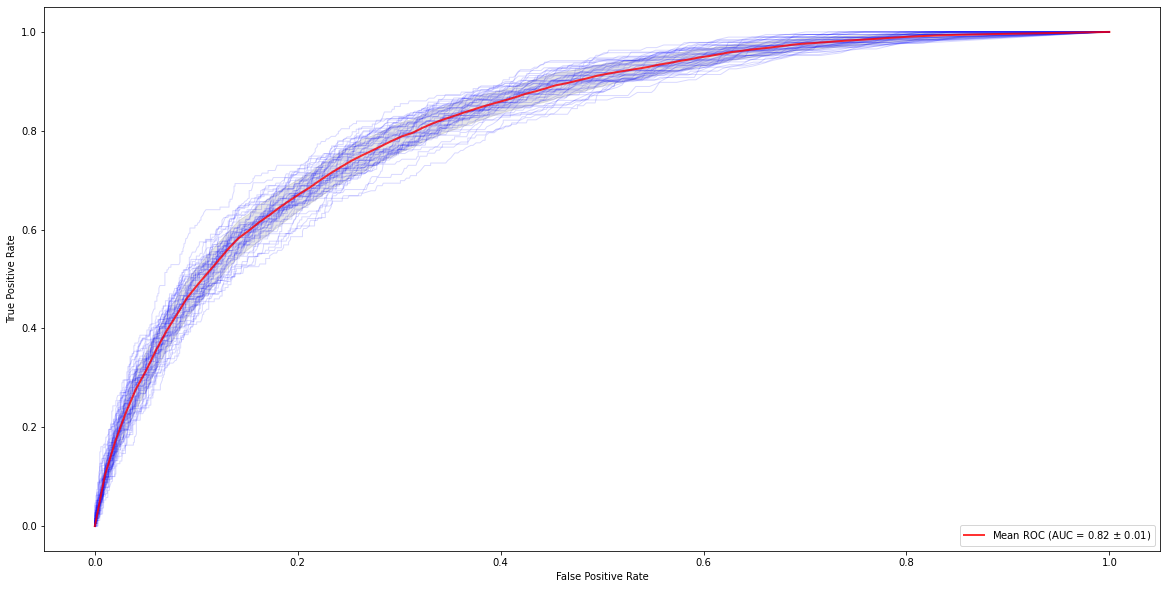

In [14]:
#- create plot instance
fig, (ax1) = plt.subplots(1, 1, figsize=(20,10))

#- go through all n model executions
for n in range(config.getint('settings', 'n_runs')):
    
    if config.getboolean('general', 'verbose'):
        print('run {} of {}'.format(n+1, config.getint('settings', 'n_runs')) + os.linesep)

    #- run machine learning model and return outputs
    X_df, y_df, eval_dict = pipeline.run(X, Y, config, scaler, clf, out_dir)
    
    #- select sub-dataset with only datapoints with observed conflicts
    X1_df, y1_df = utils.get_conflict_datapoints_only(X_df, y_df)
    
    #- append per model execution
    out_X_df = evaluation.fill_out_df(out_X_df, X_df)
    out_y_df = evaluation.fill_out_df(out_y_df, y_df)
    out_dict = evaluation.fill_out_dict(out_dict, eval_dict)

    #- plot ROC curve per model execution
    tprs, aucs = plots.plot_ROC_curve_n_times(ax1, clf, X_df.to_numpy(), y_df.y_test.to_list(),
                                                                  trps, aucs, mean_fpr)

#- plot mean ROC curve
plots.plot_ROC_curve_n_mean(ax1, tprs, aucs, mean_fpr)

## Model evaluation

### For all data points

During the model runs, the computed model evaluation scores per model execution were stored to a dictionary. Currently, the evaluation scores used are:

* [**Accuracy**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html): the fraction of correct predictions;
* [**Precision**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html): the ratio *tp / (tp + fp)* where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative;
* [**Recall**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html): the ratio *tp / (tp + fn)* where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples;
* [**F1 score**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html): the F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0;
* [**Cohen-Kappa score**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html): is used to measure inter-rater reliability. It is generally thought to be a more robust measure than simple percent agreement calculation, as κ takes into account the possibility of the agreement occurring by chance.
* [**Brier score**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.brier_score_loss.html): the smaller the Brier score, the better, hence the naming with “loss”. The lower the Brier score is for a set of predictions, the better the predictions are calibrated. Note that the Brier loss score is relatively sensitive for imbalanced datasets;
* [**ROC score**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html): a value of 0.5 suggests no skill, e.g. a curve along the diagonal, whereas a value of 1.0 suggests perfect skill, all points along the left y-axis and top x-axis toward the top left corner. A value of 0.0 suggests perfectly incorrect predictions. Note that the ROC score is relatively insensitive for imbalanced datasets.

Let's check the mean scores over all runs:

In [15]:
for key in out_dict:
    
    print('average {0} of run with {1} repetitions is {2:0.3f}'.format(key, config.getint('settings', 'n_runs'), np.mean(out_dict[key])))

average Accuracy of run with 50 repetitions is 0.853
average Precision of run with 50 repetitions is 0.563
average Recall of run with 50 repetitions is 0.262
average F1 score of run with 50 repetitions is 0.356
average Cohen-Kappa score of run with 50 repetitions is 0.285
average Brier loss score of run with 50 repetitions is 0.107
average ROC AUC score of run with 50 repetitions is 0.820


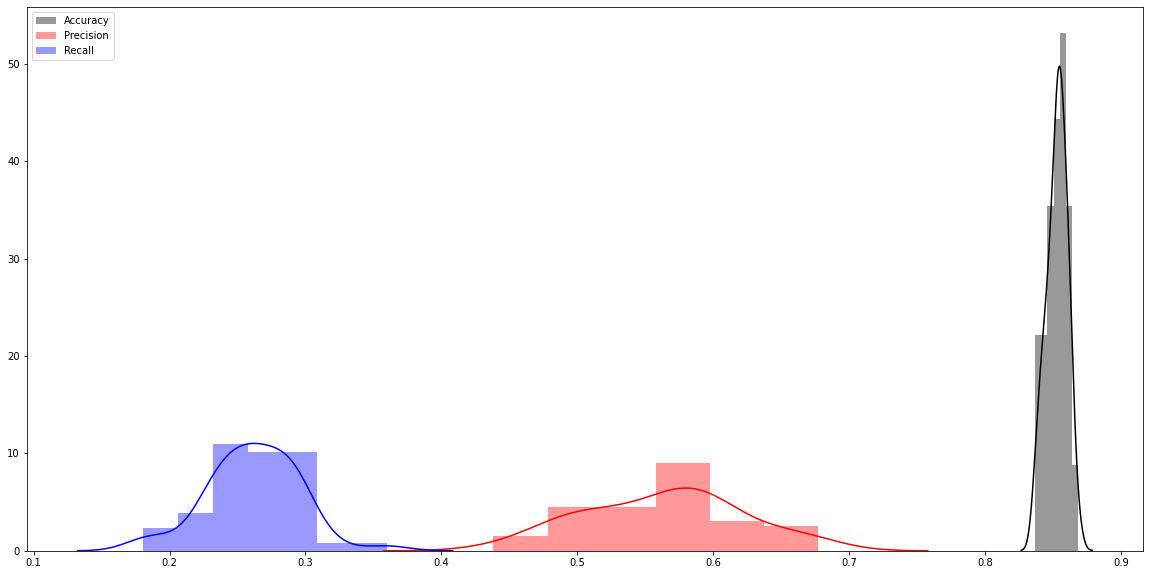

In [16]:
plots.plot_metrics_distribution(out_dict, out_dir, figsize=(20,10))

Based on all data points, the [**confusion matrix**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) can be plotted. This is a relatively straightforward way to visualize how good the classifier values are predicted by the model.

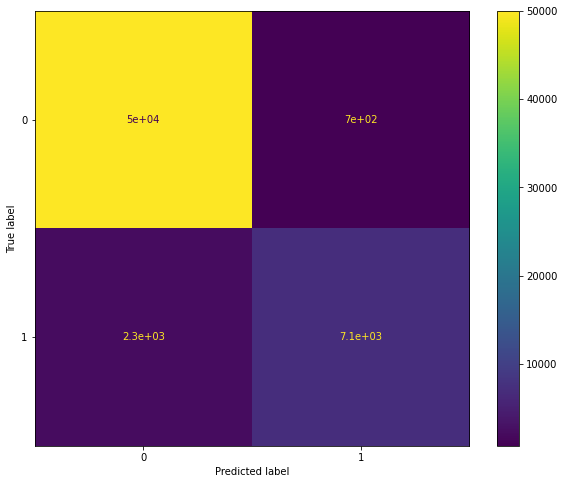

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
metrics.plot_confusion_matrix(clf, out_X_df.to_numpy(), out_y_df.y_test.to_list(), ax=ax);

### Per unique polygon

Thus far, we merely looked at numerical scores. This of course tells us a lot about the quality of the machine-learning model and its predictions, but not so much about how this looks like spatially. We therefore combine the observations and predictions made with the associated polygons based on a 'global' dataframe functioning as a look-up table. By this means, each model output can be connected to its polygon using a unique ID.

In [18]:
df_hit, gdf_hit = evaluation.polygon_model_accuracy(out_y_df, global_df, out_dir=None)

First, let's have a look at how often each polygon occurs in the all test samples, i.e. those obtained by appending the test samples per model execution. Besides, the overall relative distribution is visualized.

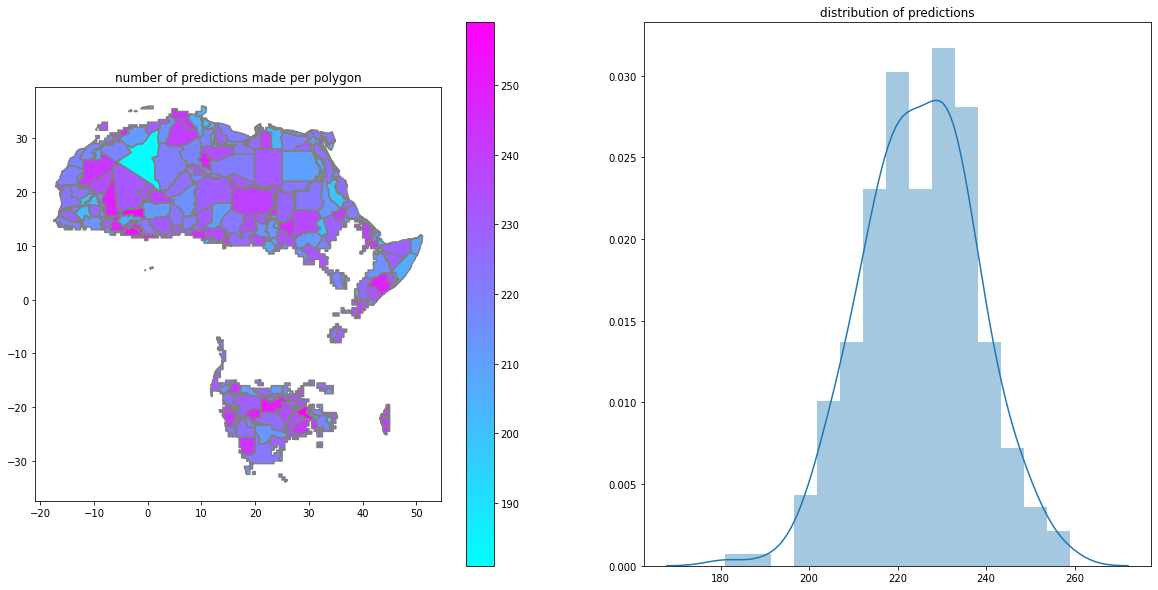

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
gdf_hit.plot(ax=ax1, column='ID_count', legend=True, cmap='cool')
selected_polygons_gdf.boundary.plot(ax=ax1, color='0.5')
ax1.set_title('number of predictions made per polygon')
sbs.distplot(df_hit.ID_count.values, ax=ax2)
ax2.set_title('distribution of predictions');

By repeating the model n times, the aim is to represent all polygons in the resulting test sample. The fraction is computed below. 

Note that is should be close to 100 % but may be slightly less. This can happen if input variables have no data for one polygon, leading to a removal of those polygons from the analysis. Or because some polygons and input data may not overlap.

In [20]:
print('{0:0.2f} % of all active polygons are considered in test sample'.format(len(gdf_hit)/len(selected_polygons_gdf)*100))

97.45 % of all active polygons are considered in test sample


By aggregating results per polygon, we can now assess model output spatially. Three main aspects are presented here:

1. The chance of a correct prediction, defined as the ratio of number of correct predictions made to overall number of predictions made;
2. The total number of conflicts in the test data;
3. The chance of conflict, defined as the ration of number of conflict predictions to overall number of predictions made.

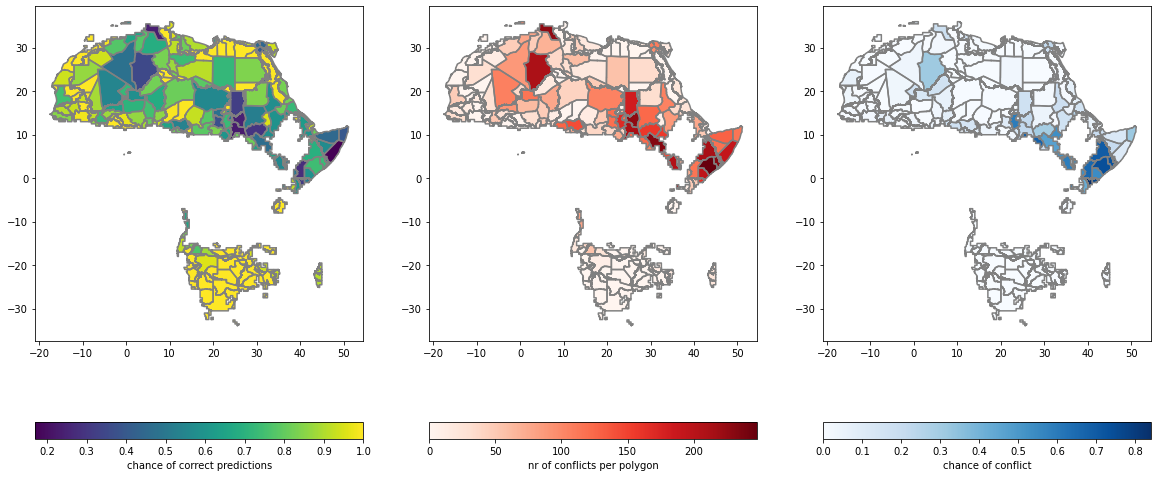

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
gdf_hit.plot(ax=ax1, column='chance_correct_pred', legend=True, 
             legend_kwds={'label': "chance of correct predictions", 'orientation': "horizontal"})
selected_polygons_gdf.boundary.plot(ax=ax1, color='0.5')
gdf_hit.plot(ax=ax2, column='nr_test_confl', legend=True, cmap='Reds', 
             legend_kwds={'label': "nr of conflicts per polygon", 'orientation': "horizontal"})
selected_polygons_gdf.boundary.plot(ax=ax2, color='0.5')
gdf_hit.plot(ax=ax3, column='chance_correct_confl_pred', legend=True, cmap='Blues', 
             legend_kwds={'label': "chance of conflict", 'orientation': "horizontal"})
selected_polygons_gdf.boundary.plot(ax=ax3, color='0.5');

To get the variation of CCP (chance of corret prediction) per polygon, we split up the entire output data in 10 parts and calcualte mean, median, and standard deviation of CCP.

In [22]:
gdf_CCP = evaluation.calc_kFold_polygon_analysis(out_y_df, global_df, out_dir=None)

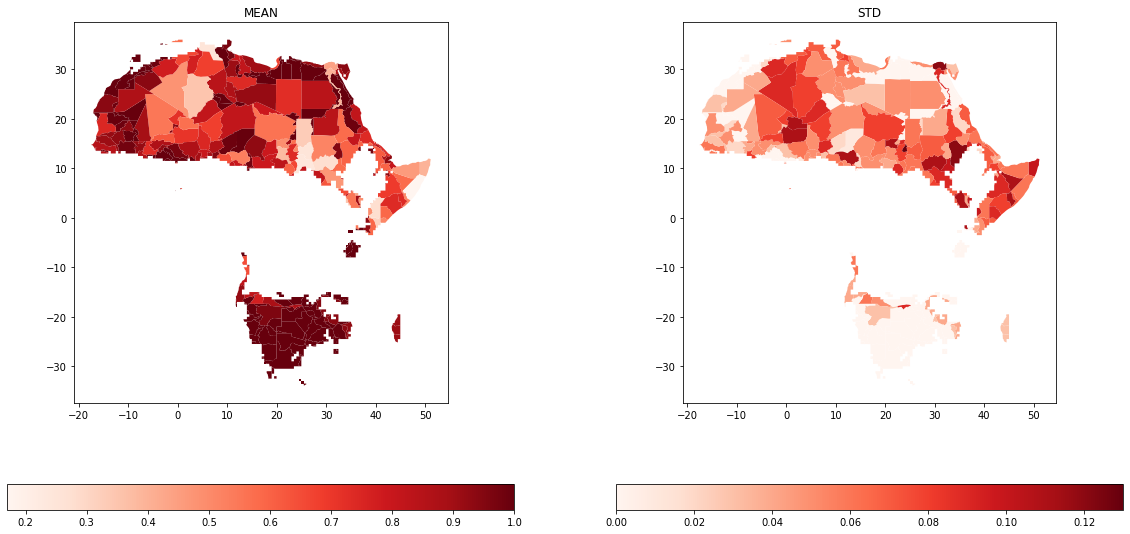

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
gdf_CCP.plot(column='mean_CCP', ax=ax1, cmap='Reds', legend=True, legend_kwds={'orientation': "horizontal"})
ax1.set_title('MEAN')
gdf_CCP.plot(column='std_CCP', ax=ax2, cmap='Reds', legend=True, legend_kwds={'orientation': "horizontal"})
ax2.set_title('STD');

To understand to what extent the model accuracy (i.e. hits) may depend on the number of predictions made per polygon or other factors, we plot some simple scatter plots.

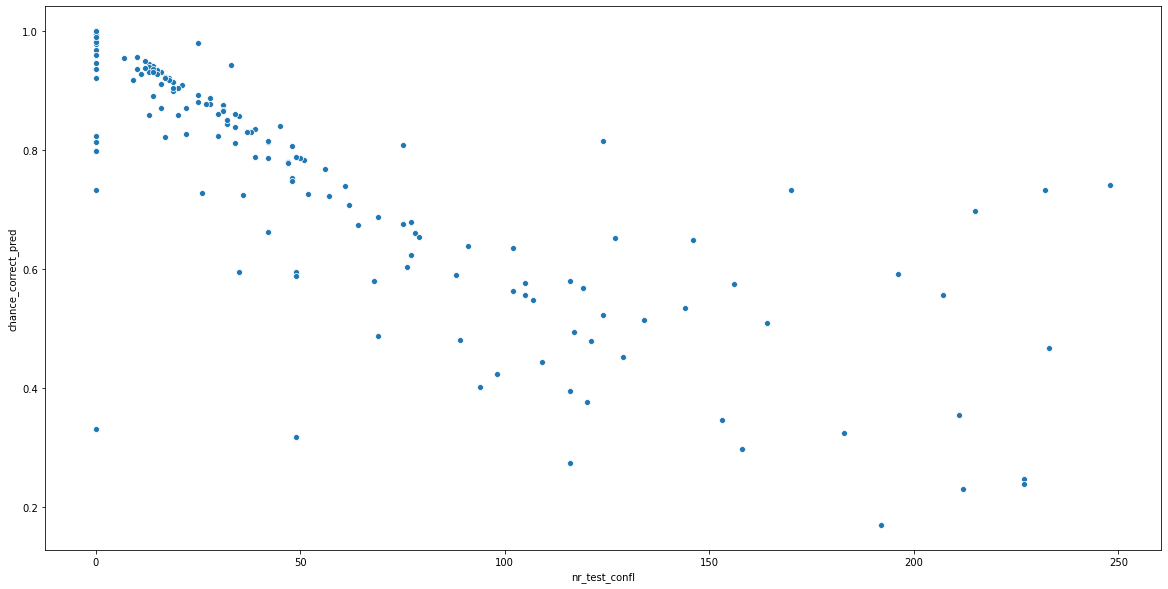

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
sbs.scatterplot(data=df_hit, x='nr_test_confl', y='chance_correct_pred', ax=ax)

Up to know, we looked at two or more indicators of how the model performed and other statistical analyses per polygon. It's now time to come up with an indicator for which polygons we 'trust' the model.

Thus, we compute the median of the average hit accuracy of all polygons. This allows for dividing the polygons in the 50 % with an average hit accuracy above the median, and the other 50 % below it. These are our main categories:

* 'H': upper 50 % of average hit accuracy;
* 'L': lower 50 % of average hit accuracy.

In addition, we may want to know how this categorization depends on the number of conflicts in a polygon. For example, wich polygons have a high accuracy with lots of conflicts? For these polygons, we could assume that the model robustly succeeds in predicting conflict. To that end, we also compute the median number of conflicts per polygon.

This yields four sub-categories:

* 'HH': upper 50 % of average hit accuracy and upper 50 % of number of conflicts;
* 'HL': upper 50 % of average hit accuracy, but then with lower 50 % of number of conflicts;
* 'LH': lower 50 % of average hit accuracy and upper 50 % of number of conflicts;
* 'LL': lower 50 % of average hit accuracy, but then with lower 50 % of number of conflicts.

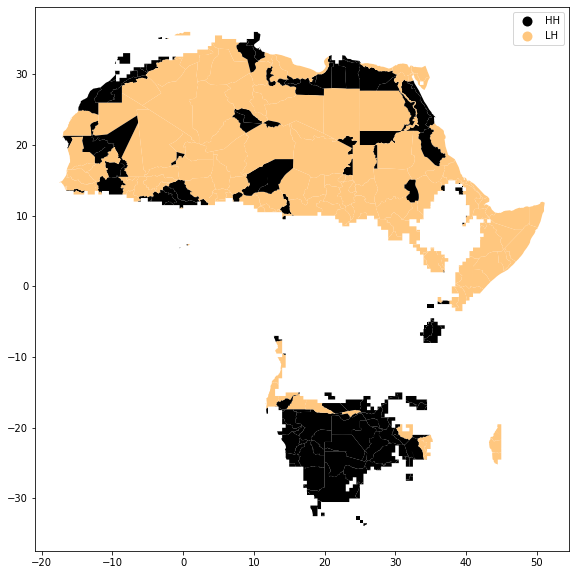

In [25]:
plots.plot_categories(gdf_hit, out_dir, category='sub')

Last, we can determine the relative importance of each feature, that is variable.

In [30]:
rel_importance = evaluation.get_feature_importance(clf, out_dir, config)

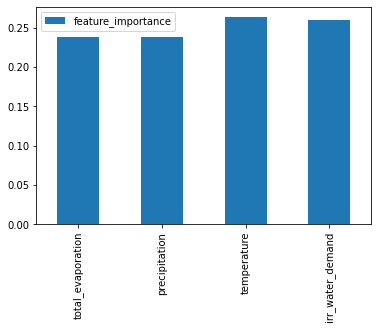

In [32]:
rel_importance.plot.bar();